# Document Access Control Classifier

This notebook builds a machine learning model to classify document access requests as either 'deny' or 'flag' based on various features.


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
df = pd.read_csv('synthetic_access_data_10000.csv')

# Select only the required columns
required_columns = [
    'user_role',
    'department',
    'employee_status',
    'resource_type',
    'resource_sensitivity',
    'action',
    'past_violations',
    'is_approved'
]

df = df[required_columns]

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user_role             10000 non-null  object
 1   department            10000 non-null  object
 2   employee_status       10000 non-null  object
 3   resource_type         10000 non-null  object
 4   resource_sensitivity  10000 non-null  object
 5   action                10000 non-null  object
 6   past_violations       10000 non-null  int64 
 7   is_approved           10000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 625.1+ KB
None

First few rows:


,user_role,department,employee_status,resource_type,resource_sensitivity,action,past_violations,is_approved
0,Manager,IT,Full-time,doc,confidential,delete,0,1
1,Contractor,Operations,Part-time,doc,restricted,download,0,1
2,Manager,Operations,Contract,spreadsheet,public,read,3,0
3,Intern,Finance,Contract,video,public,download,1,1
4,Intern,Legal,Terminated,spreadsheet,restricted,edit,5,0


In [12]:
# Data preprocessing
# Create separate LabelEncoder instances for each categorical column
label_encoders = {}
categorical_columns = ['user_role', 'action', 'department', 'resource_sensitivity']

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col + '_encoded'] = label_encoders[col].fit_transform(df[col])

# Create feature matrix X and target variable y
feature_columns = [
    'user_role_encoded', 
    'action_encoded',
    'department_encoded',
    'resource_sensitivity_encoded',
    'past_violations'
]


X = df[feature_columns]
y = df['is_approved']  # Using is_approved as our target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1367
           1       0.74      0.81      0.78       633

    accuracy                           0.85      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.86      0.85      0.85      2000



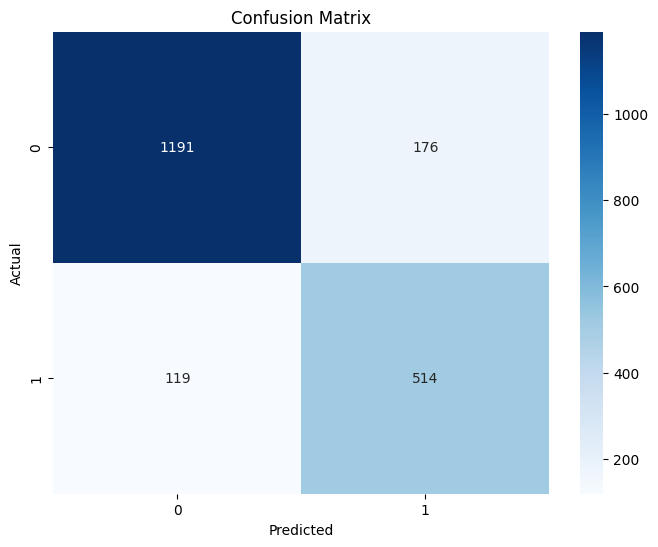

In [13]:
# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

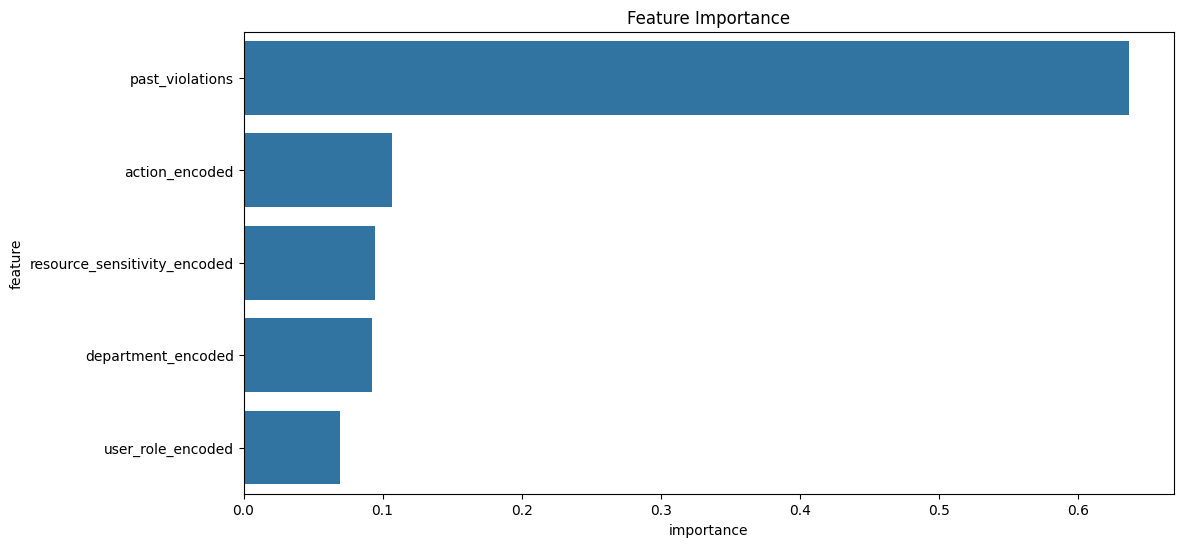

In [14]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [15]:
# Function to predict access for new requests (without resource_type and employee_status)
def predict_access(user_role, action, department, 
                   resource_sensitivity, past_violations):
    # Encode categorical variables using the appropriate label encoder
    role_encoded = label_encoders['user_role'].transform([user_role])[0]
    action_encoded = label_encoders['action'].transform([action])[0]
    dept_encoded = label_encoders['department'].transform([department])[0]
    sensitivity_encoded = label_encoders['resource_sensitivity'].transform([resource_sensitivity])[0]
    
    # Create feature array (excluding resource_type and employee_status)
    features = np.array([[role_encoded, action_encoded, dept_encoded,
                          sensitivity_encoded, past_violations]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    prediction = rf_classifier.predict(features_scaled)[0]
    probability = rf_classifier.predict_proba(features_scaled)[0]
    
    return prediction, probability


In [16]:
df['action_encoded'].head(10)
df['action'].head(10)

0      delete
1    download
2        read
3    download
4        edit
5    download
6       share
7    download
8      delete
9        read
Name: action, dtype: object

In [17]:
# Save the trained model and necessary components
import joblib

# Create a dictionary containing all necessary components
model_components = {
    'classifier': rf_classifier,
    'scaler': scaler,
    'label_encoders': label_encoders
}

# Save the model components to a file
joblib.dump(model_components, 'access_control_model.joblib')

print("Model and components saved successfully to 'access_control_model.joblib'")

# Example of loading the model
loaded_components = joblib.load('access_control_model.joblib')
print("\nModel loaded successfully. Components available:")
print("- Random Forest Classifier")
print("- StandardScaler")
print("- Label Encoders")


Model and components saved successfully to 'access_control_model.joblib'

Model loaded successfully. Components available:
- Random Forest Classifier
- StandardScaler
- Label Encoders


In [18]:
# Test the loaded model with a new case
test_case = {
    'user_role': 'Admin',
    'action': 'read',
    'department': 'IT',
    'resource_sensitivity': 'restricted',
    'past_violations': 0
}

# Load the model components
loaded_components = joblib.load('access_control_model.joblib')
loaded_classifier = loaded_components['classifier']
loaded_scaler = loaded_components['scaler']
loaded_encoders = loaded_components['label_encoders']

# Encode categorical variables using the loaded encoders
role_encoded = loaded_encoders['user_role'].transform([test_case['user_role']])[0]
action_encoded = loaded_encoders['action'].transform([test_case['action']])[0]
dept_encoded = loaded_encoders['department'].transform([test_case['department']])[0]
sensitivity_encoded = loaded_encoders['resource_sensitivity'].transform([test_case['resource_sensitivity']])[0]

# Create feature array
features = np.array([[role_encoded, action_encoded, 
                     dept_encoded, sensitivity_encoded,
                     test_case['past_violations']]])

# Scale features
features_scaled = loaded_scaler.transform(features)

# Make prediction
prediction = loaded_classifier.predict(features_scaled)[0]
probability = loaded_classifier.predict_proba(features_scaled)[0]

print(f"\nAccess Request Details:")
print(f"User Role: {test_case['user_role']}")
print(f"Action: {test_case['action']}")
print(f"Department: {test_case['department']}")
print(f"Resource Sensitivity: {test_case['resource_sensitivity']}")
print(f"Past Violations: {test_case['past_violations']}")
print(f"\nPrediction: {'Grant' if prediction else 'Deny/Flag'}")
print(f"Confidence: {max(probability)*100:.2f}%")



Access Request Details:
User Role: Admin
Action: read
Department: IT
Resource Sensitivity: restricted
Past Violations: 0

Prediction: Grant
Confidence: 88.24%


d:\Cuda_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [19]:
# Test another instance with different characteristics (updated for reduced feature set)
print("\nTesting another instance:")
test_case = {
    'user_role': 'Intern',
    'action': 'delete',
    'department': 'Finance',
    'resource_sensitivity': 'confidential',
    'past_violations': 3
}

# Call the prediction function with only the required parameters
prediction, probability = predict_access(
    user_role=test_case['user_role'],
    action=test_case['action'],
    department=test_case['department'],
    resource_sensitivity=test_case['resource_sensitivity'],
    past_violations=test_case['past_violations']
)

# Display full access request details (including unused fields)
print(f"\nAccess Request Details:")
print(f"User Role: {test_case['user_role']}")
print(f"Action: {test_case['action']}")
print(f"Department: {test_case['department']}")
print(f"Resource Sensitivity: {test_case['resource_sensitivity']}")
print(f"Past Violations: {test_case['past_violations']}")

print(f"\nPrediction: {'Grant' if prediction else 'Deny/Flag'}")
print(f"Confidence: {max(probability)*100:.2f}%")



Testing another instance:

Access Request Details:
User Role: Intern
Action: delete
Department: Finance
Resource Sensitivity: confidential
Past Violations: 3

Prediction: Deny/Flag
Confidence: 100.00%


d:\Cuda_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
